# Positive Classifications

Balanced accuracy is misleading: We don't care about the false positives. But it's not obvious that this is a factor in our calculations. This notebook generates a plot that shows all the false positives for an ATLAS object.

In [1]:
import re
import warnings

import aplpy
import astropy.io
import h5py
import matplotlib.pyplot as plt
import numpy

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy

INCHES_PER_PT = 1.0 / 72.27
COLUMN_WIDTH_PT = 240.0
FONT_SIZE_PT = 8.0

pgf_with_latex = {
    "pgf.texsystem": "pdflatex",
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": [],
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": FONT_SIZE_PT,
    "font.size": FONT_SIZE_PT,
    "legend.fontsize": FONT_SIZE_PT,
    "xtick.labelsize": FONT_SIZE_PT,
    "ytick.labelsize": FONT_SIZE_PT,
    "figure.figsize": (COLUMN_WIDTH_PT * INCHES_PER_PT, 0.8 * COLUMN_WIDTH_PT * INCHES_PER_PT),
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",
        r"\usepackage[T1]{fontenc}",
    ]
}
matplotlib.rcParams.update(pgf_with_latex)

In [2]:
table = astropy.io.ascii.read('/Users/alger/data/Crowdastro/one-table-to-rule-them-all.tbl')

In [3]:
rgzcat = astropy.io.ascii.read(
            '/Users/alger/data/RGZ/dr1_weighted_old/static_rgz_host_full.csv')
rgz_ras = rgzcat['SWIRE.ra']
rgz_decs = rgzcat['SWIRE.dec']
norris_swires = astropy.io.ascii.read(
            '/Users/alger/data/ATLAS/swire_positives_norris_06.txt')['SWIRE']
norris_ras = []
norris_decs = []

for swire in norris_swires:
    m = re.match(r'J(\d\d)(\d\d)(\d\d\.\d\d)(-\d\d)(\d\d)(\d\d\.\d)', swire)
    if not m:
        continue
    
    ra = ' '.join(m.groups()[:3])
    dec = ' '.join(m.groups()[3:])
    coord = astropy.coordinates.SkyCoord(ra=ra, dec=dec, unit=('hourangle', 'deg'))
    norris_ras.append(coord.ra.deg)
    norris_decs.append(coord.dec.deg)

In [4]:
crowdastrocat = h5py.File('/Users/alger/data/Crowdastro/crowdastro-swire.h5', 'r')
swire_ras = crowdastrocat['/swire/cdfs/numeric'][:, 0]
swire_decs = crowdastrocat['/swire/cdfs/numeric'][:, 1]

In [5]:
predictions = astropy.io.ascii.read('/Users/alger/data/Crowdastro/predicted_swire_table_cdfs_19_08_17.csv')
predictions_ra = predictions['RA']
predictions_dec = predictions['Dec']
predictions_pos = predictions['LR(RGZ / All)'] > 0.5

ATLAS3_J032929.61-281938.9C
INFO: Auto-setting vmin to -3.936e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.305e+02 [aplpy.core]
INFO: Auto-setting resolution to 100.209 dpi [aplpy.core]


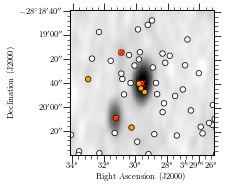

In [15]:
keys = []
for row in table:
    if row['Component Zooniverse ID (RGZ)'] and row['Source SWIRE (Norris)']:
        keys.append(row['Key'])

row = table[keys[164]]
print(row['Component Name (Franzen)'])

fits_path = '/Users/alger/data/RGZ/cdfs/2x2/' + row['Component ID (Franzen)'] + '_radio.fits'

with warnings.catch_warnings():
    warnings.simplefilter('ignore', astropy.wcs.FITSFixedWarning)
    fig = plt.figure()
    fig = aplpy.FITSFigure(fits_path, figure=fig)
    fig.show_grayscale(invert=True, stretch='arcsinh')
    fig.show_markers(rgz_ras, rgz_decs, marker='x', s=30, linewidth=0.75, c='red', zorder=2)
    fig.show_markers(predictions_ra, predictions_dec, marker='o', s=30, linewidth=0.75,
                     c=numpy.where(predictions_pos, 'orange', 'white'), edgecolor='black', zorder=1)
    fig.set_theme('publication')
    fig.set_tick_labels_format(xformat='hh:mm:ss',yformat='dd:mm:ss')
    fig.axis_labels.set_xtext('Right Ascension (J2000)')
    fig.axis_labels.set_ytext('Declination (J2000)')
#     fig.tick_labels.set_font(size='xx-large', weight='medium', \
#                              stretch='normal', family='sans-serif', \
#                              style='normal', variant='normal')
#     fig.axis_labels.set_font(size='xx-large', weight='medium', \
#                              stretch='normal', family='sans-serif', \
#                              style='normal', variant='normal')
#     fig.set_tick_labels_format(xformat='hh:mm:ss',yformat='dd:mm:ss')
    fig.save('/Users/alger/repos/crowdastro-projects/ATLAS-CDFS/images/positives.pdf')